In [1]:
import tensorflow as tf
import tensorflowjs
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from pathlib import Path
import sys

base_dir = Path('/Users/IllarionK/Projects/master_degree/tf_transfer/models/')
res_dir = base_dir / 'saved'
res_dir.mkdir(exist_ok=True, parents=True)
js_res_dir = base_dir / 'converted'
js_res_dir.mkdir(exist_ok=True, parents=True)

from tf_transfer.constants import *
from tf_transfer.tf_solver import *

2021-11-13 02:47:52.236459: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Initializer import

class Initializer(tf.Module):
    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.float32)])
    def initialize(self, dummy):
        x = init_poiseuille()
        return tf.cast(x, tf.float32)
    
initializer = Initializer()
model_path = str(res_dir / 'initializer')
tf.saved_model.save(initializer, model_path)
initializer_restored = tf.saved_model.load(model_path)

F_tf = initializer_restored.signatures['serving_default'](dummy=tf.constant(42.0))['output_0']

INFO:tensorflow:Assets written to: /Users/IllarionK/Projects/master_degree/tf_transfer/models/saved/initializer/assets


In [6]:
# Visualizer import

velocity_color_map = plt.get_cmap('viridis')

@tf.function
def velocity_to_image(u):
    vmin = tf.reduce_min(u)
    vmax = tf.reduce_max(u)
    value = (u - vmin) / (vmax - vmin)
    value = tf.squeeze(value)
    indices = tf.cast(tf.round(value * 255), tf.int32)
    colors = tf.constant(velocity_color_map.colors, dtype=tf.float32)
    value = tf.gather(colors, indices)
    value_casted = tf.cast(tf.round(value * 255), tf.int32)
    # add alpha channel
    alpha_channel = tf.cast(tf.ones((100, 400, 1)) * 255, tf.int32)
    value_with_alpha = tf.concat([value_casted, alpha_channel], 2)
    return tf.cast(value_with_alpha, tf.uint8)
    

class PrePlotter(tf.Module):
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, 9], dtype=tf.float32)])
    def pre_plot(self, F):
#         u, vort = pre_plot_inner(F)
        u = pre_plot_inner(F)
        return velocity_to_image(u)
        

# Idea - can we use `import tensorflowjs as tfjs` direct save?
# tensorflowjs.converters.save_keras_model(model, './mnist_tf_keras_js_model/')
pre_plotter = PrePlotter()
model_name = 'pre_plotter'
model_path = str(res_dir / model_name)
tf.saved_model.save(pre_plotter, model_path)
pre_plotter_restored = tf.saved_model.load(model_path)
out = pre_plotter_restored.signatures['serving_default'](F=F_tf)
tensorflowjs.converters.convert_tf_saved_model(
    saved_model_dir=model_path,
    output_dir=str(js_res_dir / model_name),
    skip_op_check=True
)
"""
can be replaced with bash call
tensorflowjs_converter models/saved/pre_plotter/ models/converted/pre_plotter --input_format=tf_saved_model
""";

INFO:tensorflow:Assets written to: /Users/IllarionK/Projects/master_degree/tf_transfer/models/saved/pre_plotter/assets


INFO:tensorflow:Assets written to: /Users/IllarionK/Projects/master_degree/tf_transfer/models/saved/pre_plotter/assets
2021-11-13 02:49:55.279753: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-11-13 02:49:55.280457: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2021-11-13 02:49:55.289230: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 54 nodes (51), 59 edges (57), time = 2.077ms.
  function_optimizer: function_optimizer did nothing. time = 0.094ms.



Writing weight file /Users/IllarionK/Projects/master_degree/tf_transfer/models/converted/pre_plotter/model.json...


2021-11-13 02:49:55.341569: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] Optimization results for grappler item: graph_to_optimize
  model_pruner: Graph size after: 48 nodes (-6), 53 edges (-6), time = 0.465ms.
  constant_folding: Graph size after: 45 nodes (-3), 50 edges (-3), time = 1.476ms.
  arithmetic_optimizer: Graph size after: 45 nodes (0), 50 edges (0), time = 0.707ms.
  dependency_optimizer: Graph size after: 41 nodes (-4), 46 edges (-4), time = 0.402ms.
  model_pruner: Graph size after: 41 nodes (0), 46 edges (0), time = 0.226ms.
  constant_folding: Graph size after: 41 nodes (0), 46 edges (0), time = 0.807ms.
  arithmetic_optimizer: Graph size after: 41 nodes (0), 46 edges (0), time = 0.643ms.
  dependency_optimizer: Graph size after: 41 nodes (0), 46 edges (0), time = 0.371ms.
  model_pruner: Graph size after: 41 nodes (0), 46 edges (0), time = 0.25ms.
  constant_folding: Graph size after: 41 nodes (0), 46 edges (0), time = 0.839ms.
  arithmetic_optimizer:

In [14]:
pre_plotter_restored.signatures

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, F) at 0x142EEBAC0>})

In [28]:
# signatures during export
# https://www.tensorflow.org/guide/saved_model#specifying_signatures_during_export


class Calculator(tf.Module):
    def __init__(self):
        super().__init__()
        self.F_res = tf.Variable(np.zeros((100, 400, 9)), dtype=dtype)
        self.wide_F_tf = tf.Variable(np.zeros((102, 402, 9)), dtype=dtype)

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[100, 400, 9],dtype=tf.float32),
#         tf.TensorSpec(shape=[None, None, 9],dtype=tf.float32),
#         tf.TensorSpec(shape=[None, None, 9],dtype=tf.float32),
    ])
    def __call__(self, F):
        F = calc_inner(F, self.F_res, self.wide_F_tf)
        F = tf.squeeze(F)
        return F

calculator = Calculator()
model_name = 'calculator'
model_path = str(res_dir / model_name)
tf.saved_model.save(calculator, model_path)
# calculator_restored = tf.saved_model.load(model_path)
# F_res = tf.Variable(F, dtype=dtype)
# wide_F_tf = tf.Variable(wide_F, dtype=dtype)
# out = calculator_restored.signatures['serving_default'](F=F_tf, F_res=F_res, wide_F_tf=wide_F_tf)

AssertionError: Tried to export a function which references 'untracked' resource Tensor("4619:0", shape=(), dtype=resource). TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly.

 Trackable Python objects referring to this tensor (from gc.get_referrers, limited to two hops):
<tf.Variable 'conv2d_3/kernel:0' shape=(1, 1, 9, 9) dtype=float32>

In [21]:
tmpdir = '/tmp'
class CustomModuleWithOutputName(tf.Module):
  def __init__(self):
    super(CustomModuleWithOutputName, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def __call__(self, x):
    return {'custom_output_name': x * self.v}

module_output = CustomModuleWithOutputName()
call_output = module_output.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
module_output_path = os.path.join(tmpdir, 'module_with_output_name')
tf.saved_model.save(module_output, module_output_path,)
#                     signatures={'serving_default': call_output})

INFO:tensorflow:Assets written to: /tmp/module_with_output_name/assets


INFO:tensorflow:Assets written to: /tmp/module_with_output_name/assets


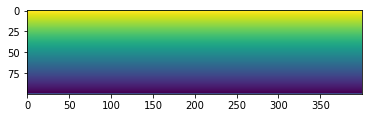

In [20]:
pylab.imshow(out['output_1'].numpy())

In [114]:
print(u_tf.dtype)
alpha_channel = tf.cast(tf.ones((100, 400, 1)) * 255, tf.uint8)
tf.concat(
    [u_tf,
    tf.ones((*u_tf.shape[:2], 1), dtype=tf.uint8)], -1
).shape

<dtype: 'uint8'>


TensorShape([100, 400, 5])

In [92]:
u_tf

<tf.Tensor: shape=(100, 400, 3), dtype=float32, numpy=
array([[[0.267004, 0.004874, 0.329415],
        [0.267004, 0.004874, 0.329415],
        [0.267004, 0.004874, 0.329415],
        ...,
        [0.267004, 0.004874, 0.329415],
        [0.267004, 0.004874, 0.329415],
        [0.267004, 0.004874, 0.329415]],

       [[0.267004, 0.004874, 0.329415],
        [0.267004, 0.004874, 0.329415],
        [0.267004, 0.004874, 0.329415],
        ...,
        [0.267004, 0.004874, 0.329415],
        [0.267004, 0.004874, 0.329415],
        [0.267004, 0.004874, 0.329415]],

       [[0.278791, 0.062145, 0.386592],
        [0.278791, 0.062145, 0.386592],
        [0.278791, 0.062145, 0.386592],
        ...,
        [0.278791, 0.062145, 0.386592],
        [0.278791, 0.062145, 0.386592],
        [0.278791, 0.062145, 0.386592]],

       ...,

       [[0.278791, 0.062145, 0.386592],
        [0.278791, 0.062145, 0.386592],
        [0.278791, 0.062145, 0.386592],
        ...,
        [0.278791, 0.062145, 0.386

In [86]:
?tensorflowjs.converters.convert_tf_saved_model

In [85]:
dir(tensorflowjs.converters)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'absolute_import',
 'common',
 'convert',
 'convert_tf_saved_model',
 'converter',
 'deserialize_keras_model',
 'division',
 'fold_batch_norms',
 'fuse_depthwise_conv2d',
 'fuse_prelu',
 'graph_rewrite_util',
 'keras_h5_conversion',
 'keras_tfjs_loader',
 'load_keras_model',
 'print_function',
 'save_keras_model',
 'tf_saved_model_conversion_v2']

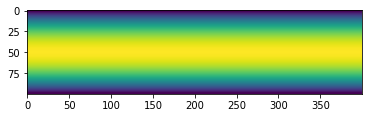

In [77]:
pylab.imshow(u_tf.numpy())

In [34]:
expanded_u_tf = tf.expand_dims(u_tf, axis=-1)
grb_u_tf = tf.image.grayscale_to_rgb(expanded_u_tf)

In [42]:
print(u_tf.numpy().min())
print(u_tf.numpy().max())

0
25


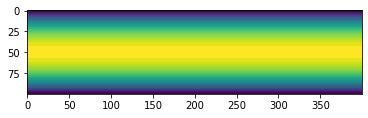

In [43]:
res = pylab.imshow(expanded_u_tf.numpy())

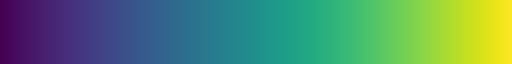

In [45]:
res.cmap

In [41]:
expanded_u_tf.numpy().min()
expanded_u_tf.numpy().max()

25

In [49]:
maps = list(sorted([m for m in plt.cm.datad if not m.endswith("_r")]))

In [53]:
res = plt.get_cmap('viridis')

In [62]:
cmp = tf.cast(tf.convert_to_tensor(res.colors) * 255, tf.uint8)

In [70]:
u_tf_norm = u_tf / tf.math.reduce_min(u_tf)
res_image = tf.gather(params=cmp, indices=tf.cast(u_tf, tf.int32))

In [73]:
value = u_tf
vmin = tf.reduce_min(value)
vmax = tf.reduce_max(value)
value = (value - vmin) / (vmax - vmin)

# squeeze last dim if it exists
value = tf.squeeze(value)

# quantize
indices = tf.cast(tf.round(value * 255), tf.int32)

# gather
cm = plt.get_cmap('viridis')
colors = tf.constant(cm.colors, dtype=tf.float32)
value = tf.gather(colors, indices)

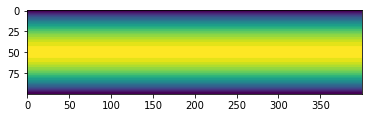

In [75]:
pylab.imshow(value.numpy())